In [1]:
# Import statements to integrate notebook with azure datastores and datasets
import azureml.core
from azureml.core import Workspace, Datastore
import os
from azureml.core import Dataset
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# workspace config information 
ws = Workspace.from_config()

# Details to access the blob storage 
blob_datastoreName='workspaceblobstore' # Name of the datastore to workspace
containerName="azureml-blobstore-d845fdc7-5370-4245-acd8-5ecb6fe12273"# Name of Azure blob container
accountName= "airporttraffic6785036281" # Storage account name

# Using Azure Blob GET API to fetch the blob datastore 
blob_datastore = Datastore.get(ws, blob_datastoreName)

# Get the registered tabular dataset by name 
ds = Dataset.get_by_name(ws, 'covid_impact_on_airport_traffic.csv')
# Converting dataset into pandas dataframe
df = ds.to_pandas_dataframe()

In [2]:
# Preparing Data 

# Data Attribute Description 
# Percentage Baseline : Proportion of trips on this date as compared to
# Avg number of trips on the same day of week in baseline period 

# Adding Weekday and month 
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
df['Month'] = pd.to_datetime(df['Date']).dt.month_name()

# Splitting Longitude and Latitudes 
df['long'] = df['Centroid'].apply(lambda x: x[6:-1].split(' ')[0])
df['lat'] = df['Centroid'].apply(lambda x: x[6:-1].split(' ')[1])

# Dropping unnecessary columns 
df.drop(columns=['Path', 'AggregationMethod', 'Version', 'Centroid'], inplace=True)

In [3]:
print("Dataframe shape ", df.shape)
df.isna().sum() # the number of null values or undefined values

Dataframe shape  (7247, 12)


Date                 0
AirportName          0
PercentOfBaseline    0
City                 0
State                0
ISO_3166_2           0
Country              0
Geography            0
Day                  0
Month                0
long                 0
lat                  0
dtype: int64

In [4]:
# Displaying the basic stats 
print("Descriptive Stats")
print(df.describe())
print("-----------------")
print("Print dataframe information")
print(df.info())
df.head()

Descriptive Stats
       PercentOfBaseline
count        7247.000000
mean           66.651442
std            22.134433
min             0.000000
25%            53.000000
50%            67.000000
75%            84.000000
max           100.000000
-----------------
Print dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 12 columns):
Date                 7247 non-null datetime64[ns]
AirportName          7247 non-null object
PercentOfBaseline    7247 non-null int64
City                 7247 non-null object
State                7247 non-null object
ISO_3166_2           7247 non-null object
Country              7247 non-null object
Geography            7247 non-null object
Day                  7247 non-null object
Month                7247 non-null object
long                 7247 non-null object
lat                  7247 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 679.5+ KB
None


,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,Day,Month,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Friday,April,151.180087713813,-33.9459774986125
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Monday,April,151.180087713813,-33.9459774986125
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Friday,July,151.180087713813,-33.9459774986125
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wednesday,September,151.180087713813,-33.9459774986125
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Saturday,October,151.180087713813,-33.9459774986125


In [5]:
# Generating a correlation matrix to understand 
# The dependencies between the different attributes. 

# Encoding Variables 
def Encode(df):
        for column in df.columns[~df.columns.isin(['PercentOfBaseline','Date'])]:
            df[column] = df[column].factorize()[0]
        return df

In [6]:
# Upon calling the Encode function, we are label encoding every
# value in its own attribute is identfied by a label. 
# This is easier for us to display a correlation matrix to understand 
# The interdependencies between the different attributes 
encoded_df = Encode(df.copy())
encoded_df.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,Day,Month,long,lat
0,2020-04-03,0,64,0,0,0,0,0,0,0,0,0
1,2020-04-13,0,29,0,0,0,0,0,1,0,0,0
2,2020-07-10,0,54,0,0,0,0,0,0,1,0,0
3,2020-09-02,0,18,0,0,0,0,0,2,2,0,0
4,2020-10-31,0,22,0,0,0,0,0,3,3,0,0


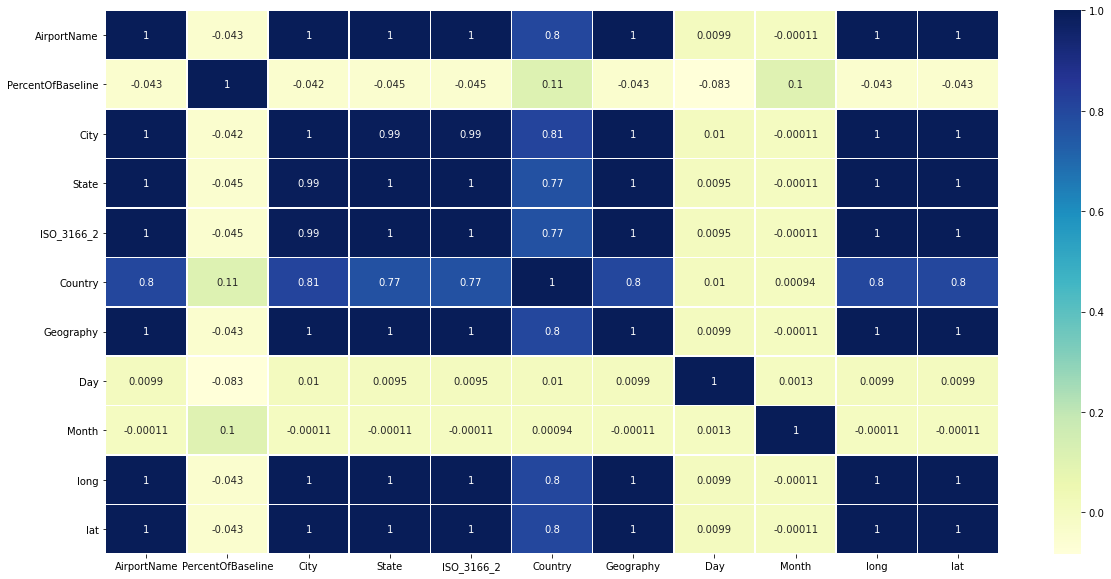

In [7]:
#correlation between variables
corrmat = encoded_df.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,10))
g = sns.heatmap(encoded_df.corr(), annot=True, linewidths=.5, cmap="YlGnBu")